In [288]:
# Fixing automatic autoreload
%load_ext autoreload
%autoreload 2

UsageError: Line magic function `%` not found.


In [14]:
import torch
import math
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from utils import (
    load_images_to_tensors,
    load_csv_to_tensors,
    calculate_TC_in_CA,
    Annotation,
    calculate_ROI_scaling_value,
    transform_points,
    translate_cell_to_tissue_coordinates,
)
from torchvision.transforms import PILToTensor

tensor_transformation = PILToTensor()

In [9]:
def read_data(data_folder_path: str) -> dict:
    """Function for reading the OCELOT data from given file path. 
    Stores the result in a dictionary. 
    """

    data = {}

    annotation_path = os.path.join(data_folder_path, "annotations")
    image_path = os.path.join(data_folder_path, "images")

    partition_folder = ["train", "val", "test"]
    file_names = []
    for folder in partition_folder: 
      tissue_partition_folder_path = os.path.join(annotation_path, folder, "tissue")
      file_names += [f.split(".")[0] for f in os.listdir(tissue_partition_folder_path)]

    for f_name in file_names: 
      # Figuring out which partition it belongs to
      if int(f_name) <= 400: 
        partition_folder = "train"
      elif int(f_name) <= 537: 
        partition_folder = "val"
      else: 
        partition_folder = "test"

      # Finding the appropriate paths for the annotations and the images
      cell_csv_path = os.path.join(annotation_path, partition_folder, "cell", f_name) + ".csv"
      tissue_annotation_path = os.path.join(annotation_path, partition_folder, "tissue", f_name) + ".png"
      tissue_image_path = os.path.join(image_path, partition_folder, "tissue", f_name) + ".jpg" 
      cell_image_path = os.path.join(image_path, partition_folder, "cell", f_name) + ".jpg" 

      # TODO: Maybe remove this?
      # Skipping files without tumor cells
      if os.path.getsize(cell_csv_path) == 0:
        print(f"Skipped file number {f_name} as the .csv was empty.")
        continue

      # Reading the annotated cell data into a dataframe and creating a tensor
      data_frame = pd.read_csv(cell_csv_path, header=None)
      cell_tensor = torch.tensor(data_frame.values)

      with Image.open(tissue_annotation_path) as img: 
        tissue_annotated_tensor = tensor_transformation(img)
      
      with Image.open(tissue_image_path) as img: 
        tissue_image_tensor = tensor_transformation(img)

      with Image.open(cell_image_path) as img: 
        cell_image_tensor = tensor_transformation(img)

      
      data[f_name] = {
        "tissue_annotated": tissue_annotated_tensor, 
        "cell_annotated": cell_tensor,
        "tissue_image": tissue_image_tensor,
        "cell_image": cell_image_tensor
        }

    return data


folder_path = "ocelot_data/"
data = read_data(data_folder_path=folder_path)

Skipped file number 217 as the .csv was empty.
Skipped file number 042 as the .csv was empty.
Skipped file number 053 as the .csv was empty.
Skipped file number 008 as the .csv was empty.
Skipped file number 392 as the .csv was empty.
Skipped file number 570 as the .csv was empty.
Skipped file number 558 as the .csv was empty.


In [10]:
# Splitting the data dictionary into tensors for future processing
tissue_tensors = []
cell_tensors = []

for file_name in sorted(list(data.keys())): 
  tissue_tensors.append(data[file_name]["tissue_annotated"])
  cell_tensors.append(data[file_name]["cell_annotated"])

tissue_tensors = torch.stack(tissue_tensors)

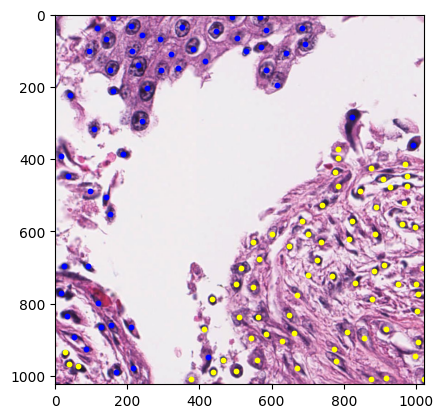

In [19]:
plt.imshow(np.transpose(data["288"]["cell_image"],(1, 2, 0)), cmap="grey")
for cor in data["288"]["cell_annotated"]: 
  x, y = cor[0], cor[1]
  color = "yellow" if cor[2] == 1 else "blue"
  plt.scatter(x, y, color=color, s=10)

## Visualization of image tissue 288

In [21]:
cell_area, tissue_area, scaling_value = calculate_ROI_scaling_value(sample_id="288")
print(cell_area)
print(tissue_area)
print(scaling_value)

tensor([27302, 24090, 28104, 24892])
tensor([25696, 22484, 28907, 25695])
tensor(0.2498)


In [23]:
cell_coordinates = data["288"]["cell_annotated"]
tissue = data["288"]["tissue_annotated"]
# cell_coordinates = cell_tensors[287]
# tissue = tissue_tensors[287]
cell_annotation = cell_coordinates[:, 2]
cell_coordinates = cell_coordinates[:, :2]

In [24]:
print(cell_coordinates[0,:])
print(cell_annotation[0])

tensor([741, 526])
tensor(1)


In [25]:
print(cell_coordinates[0, :])
cell_coordinates = translate_cell_to_tissue_coordinates(cell_coordinates, cell_area, tissue_area, scaling_value)
cell_coordinates = cell_coordinates.to(dtype=torch.int)
print(cell_coordinates[0, :])

tensor([741, 526])
tensor([697, 643], dtype=torch.int32)


In [26]:
print(tissue.size())
tissue_rgb = tissue.repeat(3, 1, 1)
print(tissue_rgb.size())

torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024])


In [27]:
def draw_circle(tensor, center, radius, color):
    cx, cy = center

    for y in range(cy - radius, cy+radius):
        for x in range(cx-radius, cx+radius):
            distance = math.sqrt((x - cx)**2 + (y - cy)**2)
            if distance <= radius:
                tensor[:, y, x] = torch.tensor(color, dtype=torch.uint8)


# Drawing red circles around the points
radius = 3  # Radius of the circle
color_blue = [0, 0, 255]  # Blue color
color_yellow = [255, 255, 0]  # Yellow color
for point, annotation in zip(cell_coordinates, cell_annotation):
    if annotation == 2:
        draw_circle(tissue_rgb, point, radius, color_blue)
    else:
        draw_circle(tissue_rgb, point, radius, color_yellow)

In [28]:
img = Image.fromarray(tissue_rgb.permute(1, 2, 0).numpy(), mode="RGB")
img.show() 

## Calculate tumor cells in cancer area

In [29]:
data_folder_path = "ocelot_data/metadata.json"

with open(data_folder_path, "r") as file:
    metadata = json.load(file)

samples = list(metadata["sample_pairs"].keys())
samples.sort()

table = calculate_TC_in_CA(cell_tensors, tissue_tensors, samples)

In [30]:
print(tissue_tensors[0].size())

print(table)
cell_percentage = table["TC_CA"] / (table["TC_non_CA"] + table["TC_CA"] + table["TC_UNK"])
print(f"Count of cells with annotation 2 and point value 2: {cell_percentage}")

torch.Size([1, 1024, 1024])
{'TC_CA': 48967, 'TC_non_CA': 20163, 'BC_non_CA': 30550, 'BC_UNK': 1498, 'TC_UNK': 2561, 'BC_CA': 9287}
Count of cells with annotation 2 and point value 2: 0.6830285530959256


In [31]:
our_num_TC = table["TC_CA"] + table["TC_non_CA"] + table["TC_UNK"]
paper_num_TC = 67_700 + 5_400
print(f"Our num TC: {our_num_TC}")
print(f"Paper num TC: {paper_num_TC}")

Our num TC: 71691
Paper num TC: 73100


In [32]:
import os
import pandas as pd

dirs = ["train", "test", "val"]
cancer_count = 0
non_cancer_count = 0
for dir in dirs: 

  csv_directory = "ocelot_data/annotations/" + dir + "/cell"
  csv_files = [f for f in os.listdir(csv_directory) if f.endswith(".csv")]

  for csv_file in csv_files:
      csv_path = os.path.join(csv_directory, csv_file)

      # Check if the file is empty
      if os.path.getsize(csv_path) == 0:
        print(f"{csv_path} was empty")

      else:
          # Read CSV file into a DataFrame
          data_frame = pd.read_csv(csv_path, header=None)

          # Convert DataFrame to tensor and count number of cancer cells
          tensor = torch.tensor(data_frame.values)
          cancer_count += (tensor[:,2] == 2).sum()
          non_cancer_count += (tensor[:,2] == 1).sum()

print(f"Cancer Count: {cancer_count}")
print(f"Non-Cancer Count: {non_cancer_count}")

ocelot_data/annotations/train/cell/008.csv was empty
ocelot_data/annotations/train/cell/392.csv was empty
ocelot_data/annotations/train/cell/042.csv was empty
ocelot_data/annotations/train/cell/053.csv was empty
ocelot_data/annotations/train/cell/217.csv was empty
ocelot_data/annotations/test/cell/570.csv was empty
ocelot_data/annotations/test/cell/558.csv was empty
Cancer Count: 71691
Non-Cancer Count: 41335


In [33]:
csv_directory = "ocelot_data/annotations/test/cell"
csv_files = sorted([f for f in os.listdir(csv_directory) if f.endswith(".csv")])
print(csv_files[-1])
print(len(csv_files))
print(537 + 126)

667.csv
126
663
